<a href="https://colab.research.google.com/github/Max1897/ECE7363_project/blob/main/src/ECE7363_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference: https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0  



In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import RobustScaler
import random

from datetime import datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

work_dir = "/content/drive/MyDrive/Colab Notebooks/data/Network_proj/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Process Data**  

In [3]:
#Read files
train_data = np.loadtxt(work_dir + "GEANT_train.txt",dtype = float)
test_data = np.loadtxt(work_dir + "GEANT_test.txt",dtype = float)

In [4]:

#The originate unit is 15min, the second parameter means add up "addup" units. (4 means a hour)
def change_granularity(data, addup = 1):
  data_length = data.shape[0]
  Temp = np.sum(data[0:addup],axis = 0)
  itr_end = data_length // addup
  for i in tqdm(range(1,itr_end)):
    temp0 = np.sum(data[i*addup:i*addup+addup],axis = 0)
    Temp = np.vstack((Temp,temp0))
  
  return Temp
'''
  @input:  Demand matrix :Column: demand pair, row:demand along time
  @output: SCALED AND NORMALIZED Demand matrix divided by demands pair with shape(demands pair number,data_length - sequence_size, sequence)
            and target vector with shape(demand pair number, length data_length - sequence_size)
'''
def data_prep_LSTM(data,sequence_size = 10):
  data_length = data.shape[0]
  num_dm = data.shape[1]
  data = data.T

  X = []
  Y = []
  Transformers = []
  for i in tqdm(range(num_dm)):
    d = data[i]
    trans = RobustScaler()
    d = d.reshape((-1,1))
    trans = trans.fit(d)
    d = trans.transform(d)
    d = d.flatten()
    x = []
    y = []
    for i in range(sequence_size, data_length):
      x.append(d[i-sequence_size:i])
      y.append(d[i])
    X.append(x)
    Y.append(y)
    Transformers.append(trans)
  
  X_ret = np.array(X,dtype = float)
  Y_ret = np.array(Y,dtype = float)
  X_ret = X_ret.reshape(462,X_ret.shape[1],sequence_size,1)
  Y_ret = Y_ret.reshape(462,Y_ret.shape[1],1)

  return X_ret, Y_ret,Transformers



### Delete the demands column where source and target are the same

In [5]:
num_nodes = 22
ind = []
for i in range(num_nodes):
  for j in range(num_nodes):
    if i == j :ind.append(i*num_nodes + j)

mask = np.ones((num_nodes ** 2), dtype = bool)
mask[[ind]] = False
Train_data = train_data[:,mask]
Test_data = test_data[:,mask]


<ipython-input-5-3f5071c75395>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[[ind]] = False


### Choose granularity

In [6]:
gran_addup = 2
Train_data = change_granularity(Train_data,gran_addup)
Test_data = change_granularity(Test_data,gran_addup)

  0%|          | 0/4039 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

### Get data ready to put into LSTM

In [7]:
sequence_size = 10

X_train,Y_train,train_transformers = data_prep_LSTM(Train_data,sequence_size)
X_test, Y_test,test_transformers = data_prep_LSTM(Test_data,sequence_size)

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

# **Setting up model**
   
# lstm

In [8]:
def model_setting():
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128, 
        input_shape=(sequence_size, 1)
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.5))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=["mae"])
  return model

def training(X_train,Y_train,model,i,sequence_size,epoch):
  callbacks = [
    keras.callbacks.ModelCheckpoint(
        work_dir + 'models/LSTM'+repr(i)+'.keras', 
        save_best_only=True)
  ]


  history = model.fit(
      X_train[i], Y_train[i], 
      epochs=epoch, 
      batch_size=32, 
      validation_split=0.1,
      shuffle=False,
      callbacks = callbacks,
      verbose = 0
  )
  return model
  


def Train_All_Models(X_train,Y_train,sequence_size):
  
  num_epoch = 20
  MODELS = []
  for i in tqdm(range(462)):
    model = model_setting()
    model = training(X_train,Y_train,model,i,sequence_size,num_epoch)
    
    MODELS.append(model)
    
  return  MODELS



# **Start training**
2h estimated

In [13]:
Models = []

In [ ]:
#Models = Train_All_Models(X_train,Y_train,sequence_size)


#**Model loading**
Takes about 20 min

In [14]:
if len(Models) == 0:
  for i in tqdm(range(462)):
    model = keras.models.load_model(work_dir + 'models/LSTM'+ repr(i)+'.keras')
    Models.append(model)

  0%|          | 0/462 [00:00<?, ?it/s]

#**Evaluate models**

In [15]:
Mae = []
for i in range(462):
  model = Models[i]
  results = model.evaluate(X_test[i],Y_test[i])
  Mae.append(results[1])


42/42 [==============================] - 1s 3ms/step - loss: 18.2109 - mae: 1.3533


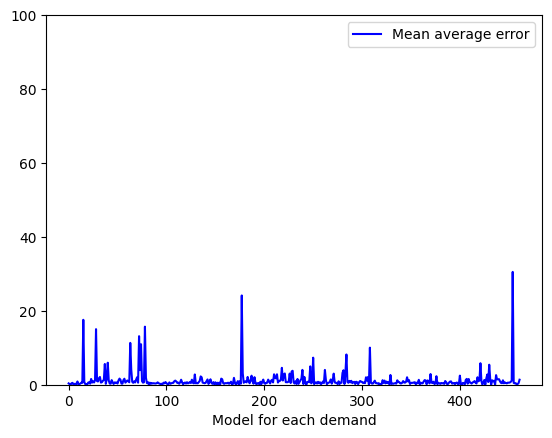

In [16]:
ax = plt.gca()
ax.set_ylim([0, 100])

plt.plot(range(462),Mae,'b',label = "Mean average error")
plt.xlabel('Model for each demand')
plt.legend()
plt.show()

f = open(work_dir + '/Evaluation.txt', 'w')
f.writelines(" ".join([str(i) for i in Mae])+"\n")
f.close()

#**Prediction**
estimated 10 min


In [17]:
'''
  @output: a data point randomly choosed, the sequence of data ahead of this data point with shape(462,10)
'''
def random_data(Test_data,sequence_size):
  
  r = random.randint(10,1345)
  return Test_data[r],Test_data[r-sequence_size:r].T

def random_scaled_data(X_test,Y_test):
  r = random.randint(10,1345)
  return Y_test[:,r,:], X_test[:,r,:,:]


def predict_next_demand_matrix(sequence_length_X_train,MODELS):
  Next_demand = []
  for i in tqdm(range(462)):
    model = MODELS[i]
    data = sequence_length_X_train[i]
    data = data.reshape((1,10,1))
    p = model.predict(data, verbose = 0)
    
    Next_demand.append(p)

  Next_demand = np.squeeze(np.array(Next_demand))
  return Next_demand




In [18]:
scaled = True

if scaled == True:
  data_point,sequences = random_scaled_data(X_test,Y_test)
  Next_demand = predict_next_demand_matrix(sequences,Models)
  data_point_inv = data_point
  Next_demand_inv = Next_demand
  for i in range(462):
    data_point_inv[i] = test_transformers[i].inverse_transform(data_point[i].reshape(-1,1))
    Next_demand_inv[i] = test_transformers[i].inverse_transform(Next_demand[i].reshape(-1,1))
else:
  data_point, sequence = random_data(Test_data,sequence_size)
  Next_demand = predict_next_demand_matrix(sequence,test_transformers)
  

  0%|          | 0/462 [00:00<?, ?it/s]

#**Output to AMPL form**

In [19]:
def prediction_vs_true(Y_test,Y_prediction,start,end): 
  plt.plot(np.arange(0, len(Y_test))[start:end], Y_test.flatten()[start:end], marker='.', label="true")
  plt.plot(np.arange(0, len(Y_test))[start:end], Y_prediction.flatten()[start:end], 'r', label="prediction")
  plt.ylabel('Demand Value')
  plt.xlabel('Time Step')
  plt.legend()
  plt.show();

def output_to_AMPL(demands,dir):
  
  demand_matrix = []
  for i in range(1,23):
    line0 = repr(i) 
    for j in range(1,23):
      if i == j: continue
      line1 = line0 + " " + repr(j)
      demand_matrix.append(line1)


  f = open(dir,'w')
  for i,d in enumerate(np.squeeze(demands)):
    if d < 0: d = 0.0
    demand_matrix[i] = repr(i+1) + " "+ demand_matrix[i] + " " + repr(d) + "\n"
    f.write(demand_matrix[i])
  f.close()

  return demand_matrix

In [20]:
now = datetime.now()
date_time = now.strftime("%d%H%M")

pred_dir = work_dir + "AMPL demands/" + date_time + "LSTM_pred.txt"
true_dir = work_dir + "AMPL demands/" + date_time + "LSTM_true.txt"
demand_matrix_pred = output_to_AMPL(Next_demand_inv,pred_dir)
demand_matrix_true = output_to_AMPL(data_point_inv,true_dir)

Compare prediction and true data for all demands on the same time step

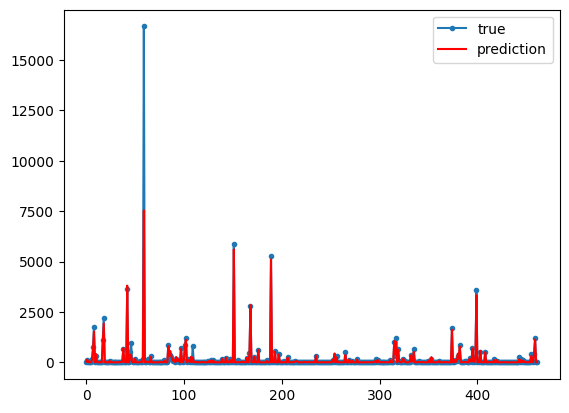

In [22]:
plt.plot(np.arange(0, len(Next_demand)), Next_demand_inv, marker='.', label="true")
plt.plot(np.arange(0, len(data_point)), data_point_inv, 'r', label="prediction")
plt.legend()
plt.show()